<a href="https://colab.research.google.com/github/vanleiko/bootcamp-alura/blob/main/Vanessa_Leiko_Treinamento_ML_dados_sirio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import seed
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

<font color="red">**IMPORTANTE:**

*A linha de código que tem a função grid_search_cv, que roda o GridSearchCV(), está comentada, pois para alguns classificadores, como o Gradient Boosting, ela demorou uns 20 minutos para rodar*

#<FONT COLOR="BLUE">**DADOS DE TREINO E TESTE, TREINAMENTO E VALIDAÇÃO DO MODELO**

##**1 - METODOLOGIA**


A metodologia seguiu o esquema da figura abaixo.

- O dataset original foi dividido em dados de treino (70%) e dados de teste (30%) com o [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

- Foi feita uma busca com o [Grid Search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) pelos melhores valores dos parâmetros dos classificadores. Grid Search CV faz uma busca exaustiva pelos melhores valores para os parâmetros especificados, dado um classificador. Os parâmetros do classificador são otimizados pela validação cruzada (CV). O scoring utilizado para avaliar a CV foi o [roc_auc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score), o qual calcula a área sob a curva ROC. 

- Com os valores dos parâmetros estabelecidos, foi feito o treinamento do modelo com os dados de treino. 

- Os dados de teste foram usados para avaliação do desempenho do modelo treinado, sendo que esses dados de teste nunca foram vistos pelo modelo. Para avaliar a performance do modelo sobre os dados de teste, utilizei as métricas AUC, Matriz de Confusão e Acurácia.

- Para verificar a estabilidade do modelo, rodei cada modelo 30 vezes, cada vez com dados de treino e teste diferentes. Para isso, a cada rodada do train_test_split, foi passada um seed diferente, que foi selecionada de maneira aleatória.

- Após avaliar a performance de cada modelo com esses diferentes dados de treino e teste, o melhor modelo foi escolhido a fim de otimizar mais ainda seus hiperparâmetros.

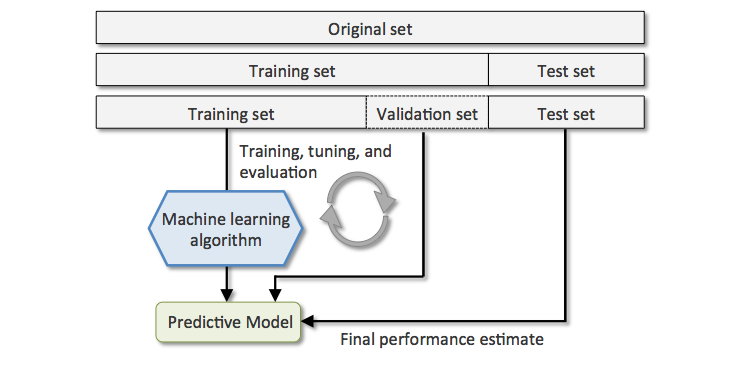

###**Sobre as métricas para avaliação dos classificadores**

- [**Curva ROC:**](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

  *Receiver Operating Characteristic Curve* ilustra, graficamente, o desempenho de um classificador binário. Essa curva é obtida pela razão da Taxa de Verdadeiros Positivos (TPR) pela Taxa de Falsos Positivos (FPR): 

${ROC}=\frac{TPR}{FPR}$

- [**AUC**](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772):

 *Area Under the Curve* é a área que está abaixo da curva ROC. O valor da AUC varia de 0 a 1; quanto mais próximo de 1, melhor é a performance do modelo.

As [figuras abaixo](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5) ilustram três casos:

- no primeiro caso, com AUC = 1, significa que em 100% das vezes, o modelo é capaz de fazer a distinção entre as duas classes:


 















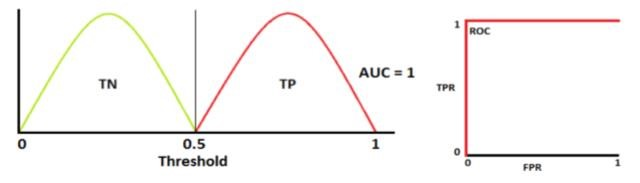

 - o segundo com AUC = 0.7, significa que o modelo é capaz de distinguir as duas classes em 70% das vezes, introduzindo os erros tipo 1 (falso negativo) e tipo 2 (falso positivo):

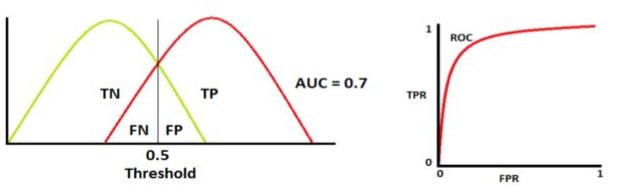

  - o último caso com AUC = 0.5, ilustra um modelo com péssimo desempenho, pois não é capaz de fazer a distinção entre as classes TP e TN:

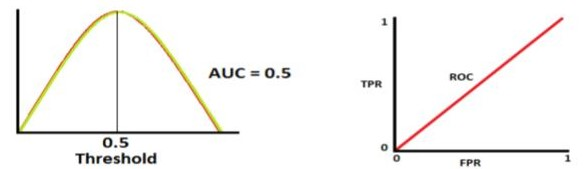

- [Matriz de Confusão:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

A Matriz de Confusão retorna visualmente os valores dos Verdadeiros Positivos (VP), Verdadeiros Negativos (VN), Falsos Positivos (FP) e Falsos Negativos (FN). Aqui, usarei esses valores normalizados (escala de 0 a 1).

Quanto mais próximo de 1 os valores de VN e VP (diagonal azul-escuro na figura abaixo), e mais próximos de zero os valores de FN e FP (diagonal azul-claro), maior a acurácia do modelo.

Olhando a linha de baixo da matriz, para a nossa situação, um maior valor de VP é ótimo e significa que o modelo é capaz de predizer os pacientes que precisarão de UTI, enquanto que um valor alto de FN é ruim, pois indica que o modelo fez a previsão de que o paciente não precisaria ir para UTI, quando na verdade ele precisará.

Na linha de cima, um valor alto de VN, que identifica corretamente quem não precisa de UTI, também é bom, pois ajuda a não sobrecarregar os leitos de UTI sem necessidade; já um valor alto de FP é ruim, pois classifica que o paciente precisa de UTI, quando na verdade ele não precisa.

Como o foco principal é identificar quem precisará de UTI, irei tentar obter melhores valores para o VP e menores valores para FN, já que estamos tratando de vidas.

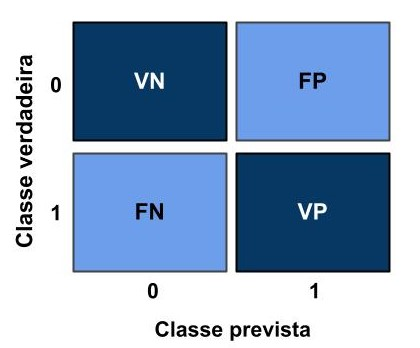

- [Acurácia:](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

A acurácia representa o quanto o modelo conseguiu acertar as classes verdadeiras (VN e VP) em relação à quantidade total da classe. Esse valor varia de 0 a 1, sendo 1 a melhor performance.

###**Funções**

In [ ]:
'''
Seleciona os melhores valores para os hiperparâmetros usando o Grid Search CV.
Retorna os melhores valores para os hiperparâmetros
'''

def grid_search_cv(parametros, modelo, x_treino, y_treino):

  # fazendo o Grid Search CV das combinações de cada valor dos parâmetros
  modelo_grid = GridSearchCV(modelo, param_grid=parametros, cv=5, scoring="roc_auc")

  # treinar o modelo
  modelo_grid.fit(x_treino, y_treino)

  # obter os melhores valores para cada parâmetro
  best_params = modelo_grid.best_params_

  return best_params

In [ ]:
'''
Essa função faz a avaliação do modelo treinado com os dados de teste
Plota a curva ROC 
''' 

def testa_modelo(modelo, x_teste, y_teste, nome_modelo): 
 
  # probabilidade de y com os dados de teste
  y_pred_proba = modelo.predict_proba(x_teste)

  # plotar a curva ROC
  fig, ax = plt.subplots(figsize=(6,6))

  ax.set_title(f"ROC Curve - {nome_modelo}", fontsize=18, fontweight="bold")
  ax.grid(linestyle='--')

  plot_roc_curve(modelo, x_teste, y_teste, ax=ax)

  ax.set_ylabel("True Positive Rate", fontsize=18)
  ax.set_xlabel("False Positive Rate", fontsize=18)
  ax.legend(fontsize="large", loc="lower right");

In [ ]:
'''
Essa função plota a matriz de confusão dos dados de teste e imprime a acurácia 
'''
def matriz_confusao(modelo, x_teste, y_teste):

  fig, ax = plt.subplots(figsize=(7,7))

  plot_confusion_matrix(modelo, x_teste, y_teste, ax=ax, normalize="true", cmap="Blues")

  ax.set_title("Confusion matrix\n(Normalized values)", fontsize=16, fontweight="bold")
  ax.set_xlabel("Predicted label", fontsize=18)
  ax.set_ylabel("True label", fontsize=18)
  
  y_pred = modelo.predict(x_teste)
  acc = accuracy_score(y_teste, y_pred)
  
  print(f"Acurácia = {acc:.3f}")

In [ ]:
'''
Essa função faz a validação cruzada (CV) dos dados de treino
Imprime a média do AUC da validação cruzada, desvio padrão, intervalo de confiança e a
diferença entre o intervalo superior e inferior
'''

def cross_val(modelo, x_treino, x_teste):

  auc = cross_val_score(modelo, x_treino, y_treino, cv=5, scoring="roc_auc")

  # média dos auc
  media_auc = np.mean(auc) 

  # desvio padrão
  std_auc = np.std(auc)

  # IC superior e IC inferior
  ic_sup = media_auc + (2 * std_auc)
  ic_inf = media_auc - (2 * std_auc)
  diff = ic_sup - ic_inf


  print(f"Média AUC = {media_auc:.3f} ± {std_auc:.3f}")
  print(f"IC inferior = {ic_inf:.3f}")
  print(f"IC superior = {ic_sup:.3f}")
  print(f"Amplitude do IC = {diff:.3f}")

In [ ]:
 '''
Essa função calcula a AUC e acurácia de cada modelo passado dos dados de teste
Devolve um dataframe com valores de AUC e ACURACIA de cada modelo
 '''

 def compara_modelos_e_cria_df_auc_acc(x_treino, y_treino, x_teste, y_teste, modelos, nomes_modelos): 

  lista_auc, lista_acc = [], [] 

  for modelo in modelos:
    modelo.fit(x_treino, y_treino)
    y_pred = modelo.predict(x_teste)
    y_pred_proba = modelo.predict_proba(x_teste)
    auc = roc_auc_score(y_teste, y_pred_proba[:,1])
    acc = accuracy_score(y_teste, y_pred)

    lista_auc.append(auc)
    lista_acc.append(acc)

  df = pd.DataFrame({"AUC_TESTE": lista_auc,
                     "ACURACIA_TESTE": lista_acc},
                    index = nomes_modelos)

  return df  


In [ ]:
'''
Plota as curvas ROC dos diferentes modelos para os dados de teste
'''

def compara_curvas_roc_modelos_diferentes(x_treino, y_treino, x_teste, y_teste, modelos):    

  fig, ax = plt.subplots(figsize=(8,8))

  for modelo in modelos:   
    modelo.fit(x_treino, y_treino)
    plot_roc_curve(modelo, x_teste, y_teste, ax=ax)

  ax.grid(linestyle='--')
  ax.set_ylabel("TPR", fontsize=18)
  ax.set_xlabel("FPR", fontsize=18)
  ax.set_title("Comparações de Curvas ROC - Dados de teste", fontsize=16, fontweight="bold")
  ax.legend(bbox_to_anchor=(1,1), fontsize="large", title="Classificadores:", title_fontsize=16, labelspacing=0.8);    


In [ ]:
'''
Gera seeds aleatórias
'''
def gera_seeds(quantidade):
  seed(0)
  lista_seeds = []

  for n in range(quantidade):
    num = random.randint(0, 100000)
    lista_seeds.append(num)
  
  return lista_seeds

In [ ]:
 '''
 Função roda um modelo n vezes e retorna todas as curvas ROC de cada rodada em um gráfico
 Imprime a média do AUC e da acurácia de todas as rodadas, mais o desvio padrão
 '''
 def compara_curvas_roc_mesmo_modelo(dados, modelo, seeds, nome_modelo): 

  x = dados.drop("ICU", axis=1)
  y = dados["ICU"]
  lista_auc, lista_acc = [], []

  fig, ax = plt.subplots(figsize=(7,7))

  for SEED in seeds:
    # separar os dados de treino e teste
    x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, test_size=0.3, random_state=SEED)
    modelo.fit(x_treino, y_treino)

    # predições de y
    y_pred = modelo.predict(x_teste)
    y_pred_proba = modelo.predict_proba(x_teste)

    # calcular AUC e ACC
    auc = roc_auc_score(y_teste, y_pred_proba[:,1])
    acc = accuracy_score(y_teste, y_pred)
    lista_auc.append(auc)
    lista_acc.append(acc)

    # plotar as curvas
    plot_roc_curve(modelo, x_teste, y_teste, ax=ax)

  ax.grid(linestyle='--')
  ax.set_ylabel("TPR", fontsize=18)
  ax.set_xlabel("FPR", fontsize=18)
  ax.set_title(f"Comparações de Curvas ROC - {nome_modelo}", fontsize=14, fontweight="bold")
  ax.legend(bbox_to_anchor=(1,1), fontsize="small", title="AUC:", title_fontsize=14, ncol=2);   
  
  # calcular as média da AUC, Acurácia e seus DP
  media_auc = np.mean(lista_auc)
  std_auc = np.std(lista_auc)
  
  media_acc = np.mean(lista_acc)
  std_acc = np.std(lista_acc)

  print(f" {nome_modelo}".center(30))
  print(f"Média AUC = {media_auc:.3f} ± {std_auc:.3f}")
  print(f"Média Acurácia = {media_acc:.3f} ± {std_acc:.3f}")
  print("-"*30)

##**2 - LEITURA DO ARQUIVO**

In [ ]:
dados_sirio = pd.read_csv("https://raw.githubusercontent.com/vanleiko/bootcamp-alura/main/dataset_sirio.csv")

In [ ]:
# ambas as classes estão bem distribuidas; dados balanceados
total = len(dados_sirio["ICU"])
classe_0 = dados_sirio["ICU"].value_counts()[0]
classe_1 = dados_sirio["ICU"].value_counts()[1]

print(f"Classe 0 ---> {(classe_0/total*100):.2f}%")
print(f"Classe 1 ---> {(classe_1/total*100):.2f}%")

Classe 0 ---> 53.69%
Classe 1 ---> 46.31%


##**3 - DADOS DE TREINO E DADOS DE TESTE**

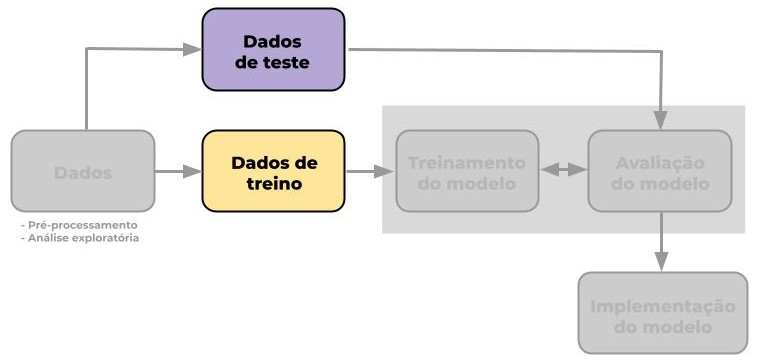

In [ ]:
# separar dados de x (features) e y (labels)
x = dados_sirio.drop("ICU", axis=1)
y = dados_sirio["ICU"]

# separar dados de treino/validação e dados de teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)

##**4 - TREINAMENTO E AVALIAÇÃO DOS MODELOS**

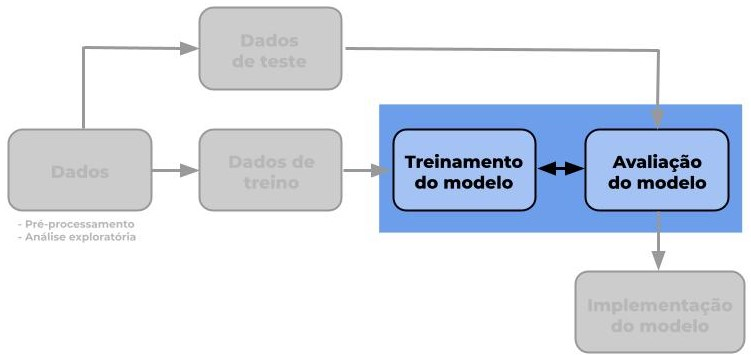

###<font color = "purple">**4.1 - DUMMY CLASSIFIER**

Para sabermos se um classificador de Machine Learning está performando bem, precisamos de alguma referência, ou seja, algum valor de comparação. O [classificador Dummy](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html?highlight=dummy#sklearn.dummy.DummyClassifier) é um classificador que faz predições utilizando as regras mais simples e, a partir dele, podemo ter uma linha de base *(baseline)* para compararmos com nossos classificadores.

Para estabeler a *baseline*, testarei as estratégias "*most_frequent*" e "*constant*" do Dummy Classifier. A primeira estratégia sempre irá predizer a classe mais frequente (no nosso dataset, é a classe 0); na segunda estratégia, é possível passar a constante que queremos que o classificador faça a previsão e, nesse caso, passarei a classe 1 como constante, já que queremos desenvolver um modelo que seja capaz de dizer quem irá para UTI.

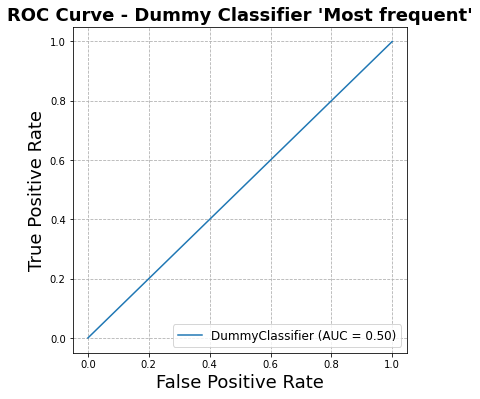

In [ ]:
# criando o modelo, estratégia Most Frequent
modelo_dummy_mf = DummyClassifier(strategy="most_frequent", random_state=0)

# treinar o modelo
modelo_dummy_mf.fit(x_treino, y_treino)

# testar o modelo nos dados de teste
testa_modelo(modelo_dummy_mf, x_teste, y_teste, "Dummy Classifier 'Most frequent'")

Acurácia = 0.538


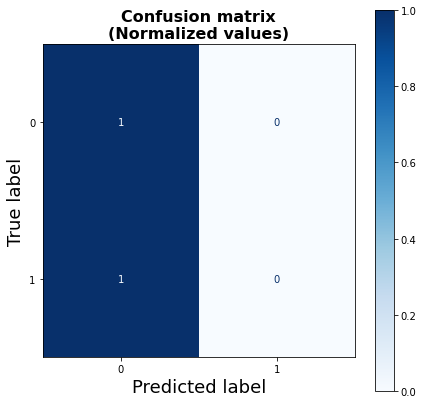

In [ ]:
# matriz de confusão
matriz_confusao(modelo_dummy_mf, x_teste, y_teste)

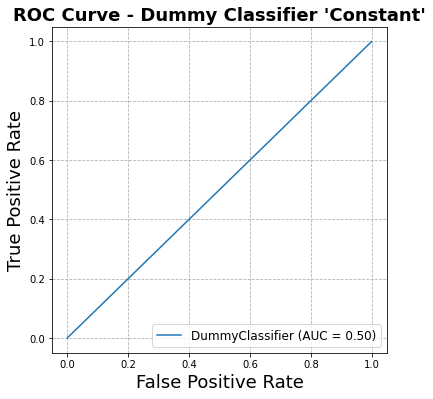

In [ ]:
# criando o modelo, estratégia Constant
modelo_dummy_ct = DummyClassifier(strategy="constant", constant=1, random_state=0)

# treinar o modelo
modelo_dummy_ct.fit(x_treino, y_treino)

# testar
testa_modelo(modelo_dummy_ct, x_teste, y_teste, "Dummy Classifier 'Constant'")

Acurácia = 0.462


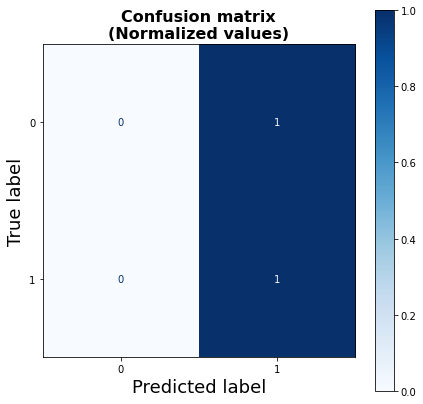

In [ ]:
# matriz de confusão
matriz_confusao(modelo_dummy_ct, x_teste, y_teste)

**COMENTÁRIOS:**

- Como ambas as estratégias apresentaram o mesmo valor de AUC (0,5), porém a estratégia "*most frequent*" foi a que apresentou maior acurácia (0.538), irei usar esses valores para a baseline.

**Baseline:**

  - AUC = 0,5 

  - ACURÁCIA = 0.538



###<font color="purple">**4.2 - KNEIGHBORS CLASSIFIER**

Esse [modelo](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) faz a classificação utilizando a classe dos k-vizinhos mais próximos.

**1 - Escolha dos valores para os hiperparâmetros do KNeighbors Classifier usando Grid Search CV**

**Hiperparâmetros avaliados:**

- n_neighbors: número de vizinhos a serem consultados

- weights: peso de cada vizinho

- algorithm: algoritmo para calcular o vizinho mais próximo

- p: parâmetro para calcular a métrica de Minkowski 




In [ ]:
# definindo os valores dos parâmetros a serem testados
parametros_kn = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
               "weights": ["uniform", "distance"],
               "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
               "p": [1, 2, 3, 4]}

# criando o modelo KNeighbors
modelo_kn = KNeighborsClassifier()

# busca Grid
# grid_search_cv(parametros_kn, modelo_kn, x_treino, y_treino)

**Hiperparâmetros**

- **n_neighbors: 12**
- **weights: uniform**
- **algorithm: auto**
- **p: 1**


**2 - Cross validation do modelo com dados de treino e tuning dos hiperparâmetros**

Aqui será o momento em que o treinamento e a validação do modelo serão realizados até os scores melhorarem, alterando alguns valores dos hiperparâmetros.

In [ ]:
# CV com os valores dos parâmetros selecionados no GridSearch
modelo_inicial_kn = KNeighborsClassifier(n_neighbors=12, weights="uniform", algorithm="auto", p=1)                                

# fazer CV
cross_val(modelo_inicial_kn, x_treino, y_treino)

Média AUC = 0.701 ± 0.066
IC inferior = 0.570
IC superior = 0.832
Amplitude do IC = 0.262


In [ ]:
# Teste 1:  weights="distance"
modelo_kn_1 = KNeighborsClassifier(n_neighbors=12, weights="distance", algorithm="auto", p=1)                                

# fazer CV
cross_val(modelo_kn_1, x_treino, y_treino)

Média AUC = 0.695 ± 0.076
IC inferior = 0.543
IC superior = 0.847
Amplitude do IC = 0.304


**3 - Testar o modelo nos dados de teste:**

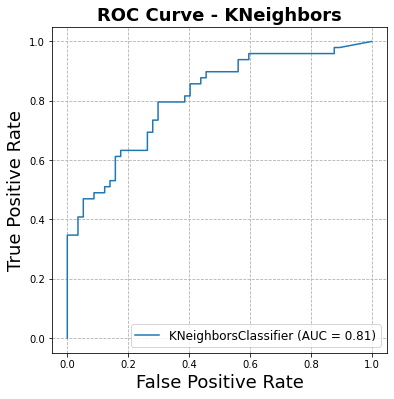

In [ ]:
# ver como esse modelo inicial se sai com os dados de teste
modelo_kn_1.fit(x_treino, y_treino)
testa_modelo(modelo_kn_1, x_teste, y_teste, "KNeighbors")

Acurácia = 0.708


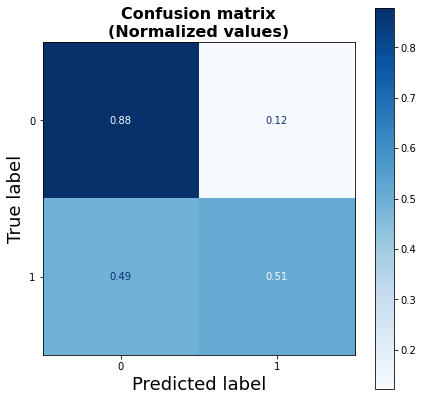

In [ ]:
# plotar a matriz de confusão dos dados de teste; valores normalizados
matriz_confusao(modelo_kn_1,  x_teste, y_teste)

**COMENTÁRIOS:**

Modelo: modelo_kn_1


- AUC = 0,81
- ACURÁCIA = 0,708

Matriz de confusão:

- Verdadeiros Negativos (VN): esse modelo tem um bom desempenho em acertar a classe 0 *(quem não irá para UTI)*, com uma taxa de acerto dos VN igual a 0,88.

- Verdadeiros Positivos (VP): como o objetivo é construir um modelo que seja bom em predizer a classe 1 *(quem irá para UTI)*, esse modelo mostrou ser mediano, com uma taxa de acerto dos VP igual a 0,51.

- Falsos Negativos (FN): esse modelo tem um valor mediano de FN (0,49), 

- Falsos Positivos (FP): Esse modelo foi bom em evitar FP (0,12).

**CONCLUSÂO:**

Esse classificador teve um desempenho bem mediano em prever quem irá para UTI (classe 1). 

###<font color="purple">**4.3 - SVC**

[Supports Vectors Classifier](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769) tenta encontrar o melhor hiperplano que separa as diferentes classes, maximizando a distância entre as amostras.

**1 - Escolha dos valores para os hiperparâmetros do SVC usando Grid Search CV**

**Hiperparâmetros avaliados:**

- kernel: seleciona o tipo de hiperplano para separar os dados
- degree: grau para achar o hiperplano e separar os dados
- gamma: parâmetro para plano não-linear; ajusta os dados de treino
-probability
- C: penalidade, controla o trade-off entre o limite de uma decisão mais suave e a classificação os pontos de treinamento corretamente

In [ ]:
parametros_svc = {"kernel": ["linear", "rbf", "poly", "sigmoid"],
                  "degree": [0, 1, 2, 3, 4, 5, 6],
                  "gamma": ["scale", "auto", 0.1, 1, 10],
                  "probability": [True, False],
                  "C": [0.1, 1, 10]}

# criando o modelo SVC
modelo_svc = SVC(random_state=0)

# busca Grid
# grid_search_cv(parametros_svc, modelo_svc, x_treino, y_treino)

**Hiperparâmtros**


- **degree: 5**
- **gamma: scale**
- **kernel: poly**
- **probability: True**
- **C: 1**

**2 - Cross validation do modelo com dados de treino e tuning dos hiperparâmetros**

Aqui será o momento em que o treinamento e a validação do modelo serão realizados até os scores melhorarem, alterando alguns valores dos hiperparâmtros.

In [ ]:
# CV com os valores dos parâmetros selecionados no GridSearch
modelo_inicial_svc = SVC(kernel="poly", degree=5, gamma="scale", C=1, probability=True)                                

# fazer CV
cross_val(modelo_inicial_svc, x_treino, y_treino)

Média AUC = 0.718 ± 0.062
IC inferior = 0.595
IC superior = 0.841
Amplitude do IC = 0.246


In [ ]:
# Teste 1: degree=4
modelo_svc_1 = SVC(kernel="poly", degree=4, gamma="scale", C=1, probability=True)                                

# fazer CV
cross_val(modelo_svc_1, x_treino, y_treino)

Média AUC = 0.710 ± 0.062
IC inferior = 0.587
IC superior = 0.834
Amplitude do IC = 0.247


In [ ]:
# Teste 1: degree=2
modelo_svc_2 = SVC(kernel="poly", degree=2, gamma="scale", C=1, probability=True)                                

# fazer CV
cross_val(modelo_svc_2, x_treino, y_treino)

Média AUC = 0.703 ± 0.051
IC inferior = 0.601
IC superior = 0.805
Amplitude do IC = 0.204


**3 - Testar o modelo nos dados de teste:**

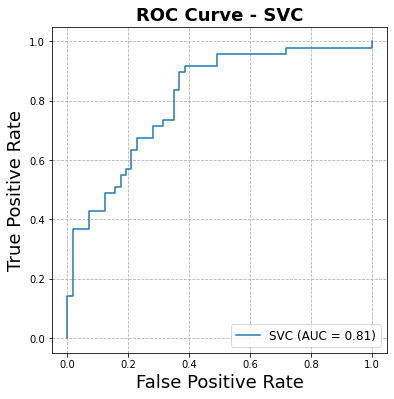

In [ ]:
# ver como esse modelo inicial se sai com os dados de teste
modelo_svc_2.fit(x_treino, y_treino)
testa_modelo(modelo_svc_2, x_teste, y_teste, "SVC")

Acurácia = 0.708


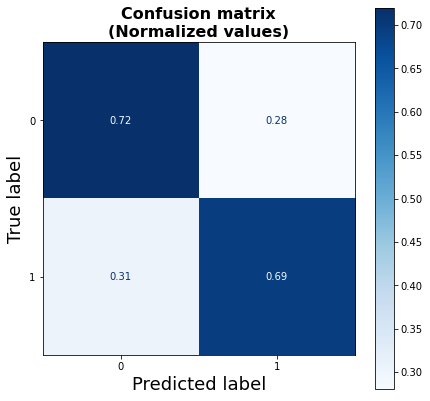

In [ ]:
# plotar a matriz de confusão dos dados de teste; valores normalizados
matriz_confusao(modelo_svc_2, x_teste, y_teste)

**COMENTÁRIOS:**

Modelo: modelo_svc_2

- AUC = 0,81
- ACURÁCIA = 0,708

Matriz de confusão:

- Verdadeiros Negativos (VN): esse modelo tem um bom desempenho em acertar a classe 0 *(quem não irá para UTI)*, com uma taxa de acerto dos VN igual a 0,72.

- Verdadeiros Positivos (VP): foi o melhor modelo em prever os VP até agora, com uma taxa de acerto igual a 0,69.

- Falsos Negativos (FN): esse modelo tem um valor ok de FN (0,31), 

- Falsos Positivos (FP): Esse modelo foi até que bom em evitar FP (0,28).

**CONCLUSÂO:**

Esse classificador teve o melhor desempenho até agora em prever a classe 1 (quem irá para UTI)

###<font color="purple">**4.4 - RANDOM FOREST CLASSIFIER**

[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) é um metaestimador que constroi várias árvores de decisão (*ensemble*) e usa suas médias para melhorar a precisão de sua predição. Ao construir várias árvores, o modelo consegue reduzir a variância e reduzir o overfitting.  

**1 - Escolha dos valores para os hiperparâmetros do Random Forest Classifier usando Grid Search CV**

**Hiperparâmetros avaliados**

- n_estimators: quantidade de árvores a ser construída *(quanto mais, melhor, porém há um nível crítico em que o aumento no número de árvores não causa melhora no modelo)*

- max_features: quantidade máxima de features do dataset a ser testada para cada árvore 

- max_depth: profundidade máxima da árvore

- bootstrap: amostrar os dados com reposição 

- oob_score: usar a estatégia "out of bag" para estimar a acurácia da generalização do modelo

- criterion: função para medir a qualidade de cada divisão


In [ ]:
# # definindo os valores dos parâmetros a serem testados
parametros_rf = {"n_estimators": [100, 200, 500],
               "max_features": ["auto", "sqrt", "log2"],
               "max_depth": [2, 3, 4, 5, 6],
               "bootstrap": ["True", "False"],
               "oob_score": ["True", "False"],
               "criterion" :["gini", "entropy"]}

# # criando o modelo Random Forest
modelo_rf = RandomForestClassifier(random_state=0)

# busca Grid
# grid_search_cv(parametros_rf, modelo_rf, x_treino, y_treino)

**Hiperparâmetros**

- **bootstrap: True**
- **criterion: gini**
- **max_depth: 2**
- **max_features: auto**
- **n_estimators: 100**
- **oob_score: True**

**2 - Cross validation do modelo com dados de treino e tuning dos hiperparâmetros**

Aqui será o momento em que o treinamento e a validação do modelo serão realizados até os scores melhorarem, alterando alguns valores dos hiperparâmetros.

In [ ]:
# CV com os valores dos parâmetros selecionados no GridSearch
modelo_inicial_rf = RandomForestClassifier(n_estimators=100, max_features="auto", max_depth=2, 
                                    bootstrap=True, oob_score=True, criterion="gini", random_state=0)

# fazer CV
cross_val(modelo_inicial_rf, x_treino, y_treino)

Média AUC = 0.749 ± 0.085
IC inferior = 0.579
IC superior = 0.919
Amplitude do IC = 0.340


In [ ]:
# TESTE 1: n_estimators=50 (MELHOROU UM POUCO) ---> usar esse modelo
modelo_rf_1 = RandomForestClassifier(n_estimators=50, max_features="auto", max_depth=2, 
                                    bootstrap=True, oob_score=True, criterion="gini", random_state=0)

# fazer CV
cross_val(modelo_rf_1, x_treino, y_treino)

Média AUC = 0.751 ± 0.083
IC inferior = 0.585
IC superior = 0.917
Amplitude do IC = 0.333


**3 - Testar o modelo nos dados de teste:**

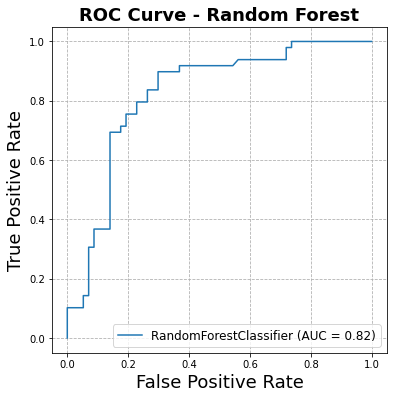

In [ ]:
# plotar a curva ROC
modelo_rf_1.fit(x_treino, y_treino)

testa_modelo(modelo_rf_1, x_teste, y_teste, "Random Forest")

Acurácia = 0.755


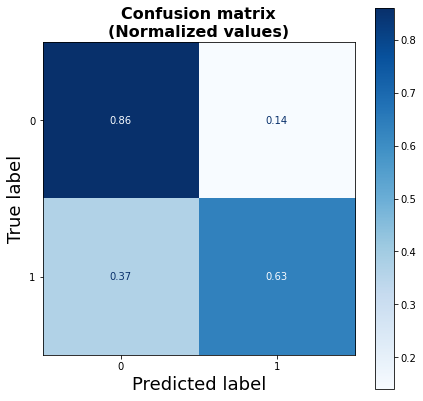

In [ ]:
# plotar a matriz de confusão dos dados de teste
matriz_confusao(modelo_rf_1, x_teste, y_teste)

**COMENTÁRIOS:**

Modelo: modelo_rf_1


- AUC = 0,82
- ACURÁCIA = 0,755

Matriz de confusão:

- Verdadeiros Negativos (VN): esse modelo tem um bom desempenho em acertar a classe 0 *(quem não irá para UTI)*, com uma taxa de acerto dos VN igual a 0,86.

- Verdadeiros Positivos (VP): como o objetivo é construir um modelo que seja bom em predizer a classe 1 *(quem irá para UTI)*, esse modelo mostrou ser mediano, com uma taxa de acerto dos VP igual a 0,63.

- Falsos Negativos (FN): esse modelo tem uma taxa um pouco alta de FN (0,37), o que pode ser ruim quando se trata de pessoas precisando de UTI. Ou seja, em 37% das vezes, o modelo previu que alguém não iria para UTI, quando na verdade ela iria para UTI.

- Falsos Positivos (FP): Esse modelo foi bom em evitar FP (0,14), isto é, não mandar pessoas para UTI quando na verdade ela não precisa de UTI, o que ajudaria a não sobrecarregar os leitos de UTI sem necessidade.

**CONCLUSÂO:**

Esse classificador teve um desempenho mediano em prever quem irá para UTI (classe 1). 

###<font color="purple">**4.5 - GRADIENT BOOSTING CLASSIFIER**

Assim como o Random Forest, o classificador [Gradient Boosting](https://towardsdatascience.com/gradient-boosting-classification-explained-through-python-60cc980eeb3d) também é do tpo *ensemble*, usando múltiplos preditores, porém, em vez de ajustar um preditor nos dados a cada iteração, esse classificador ajusta um novo preditor aos erros residuais feitos pelo preditor anterior. 

**1 - Escolha dos valores para os hiperparâmetros do Gradient Boosting Classifier usando Grid Search CV**

**Hiperparâmetros**

- loss 
- n_estimators: número de árvores a ser construída
- criterion: função para medir a qualidade de cada split
- learning_rate: constribuição de cada árvore
- max_depth: profundidade máxima da árvore
- init: estimador inicial
- min_samples_split
- min_sampes_leaf
- max_features

In [ ]:
parametros_gb_1 = {"loss": ["deviance", "exponential"],
                  "n_estimators": [50, 100, 200, 500],
                 "learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                  "max_depth": [2, 3, 4],
                  "min_samples_split": [2, 3, 4, 5],
                 "min_samples_leaf": [0.1, 0.5, 5],
                 "max_features": ["auto", "sqrt", "log2"]}

# criando o modelo SVC
modelo_gb_1 = GradientBoostingClassifier(random_state=0)


# busca Grid
# grid_search_cv(parametros_gb_1, modelo_gb_1, x_treino, y_treino)

**Hiperparâmetros 1**


- **learning_rate: 0,05**
- **loss: exponential**
- **max_depth: 2**
- **max_features: auto**
- **min_samples_leaf: 0.1**
- **min_samples_split: 2**
- **n_estimators: 50**

In [ ]:
parametros_gb_2 = {"n_estimators": [50, 100, 200, 500], 
                   "criterion": ["friedman_mse", "mse"], 
                   "learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                   "max_depth": [2, 3, 4],
                   "loss": ["deviance", "exponential"], 
                   "min_samples_split": [2, 3, 4, 5],  
                   "max_features": ["auto", "sqrt", "log2"]}
                   

# criando o modelo SVC
modelo_gb_2 = GradientBoostingClassifier(random_state=0)


# busca Grid
# grid_search_cv(parametros_gb_2, modelo_gb_2, x_treino, y_treino)

 **Hiperparâmetros 2**


- **criterion: friedman_mse**
- **learning_rate: 0.1**
- **loss: deviance**
- **max_depth: 4**
- **max_features: sqrt**
- **min_samples_split: 4**
- **n_estimators: 100**

**2 - Cross validation do modelo com dados de treino e tuning dos hiperparâmetros**

Aqui será o momento em que o treinamento e a validação do modelo serão realizados até os scores melhorarem, alterando alguns valores dos hiperparâmetros.

In [ ]:
# CV com os valores dos parâmetros selecionados no GridSearch
modelo_inicial_gb_1 = GradientBoostingClassifier(loss="exponential", max_depth=2, max_features="auto", 
                                                 min_samples_leaf=0.1, min_samples_split=2, n_estimators=50)                                

# fazer CV
cross_val(modelo_inicial_gb_1, x_treino, y_treino)

Média AUC = 0.736 ± 0.089
IC inferior = 0.559
IC superior = 0.913
Amplitude do IC = 0.354


In [ ]:
# CV com os valores dos parâmetros selecionados no GridSearch
modelo_inicial_gb2 = GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.1,
                                                max_depth=4, n_estimators=100,
                                                max_features="sqrt", min_samples_split=4,
                                                loss="deviance")

cross_val(modelo_inicial_gb2, x_treino, y_treino)

Média AUC = 0.738 ± 0.056
IC inferior = 0.626
IC superior = 0.850
Amplitude do IC = 0.224


**3 - Testar o modelo nos dados de teste:**

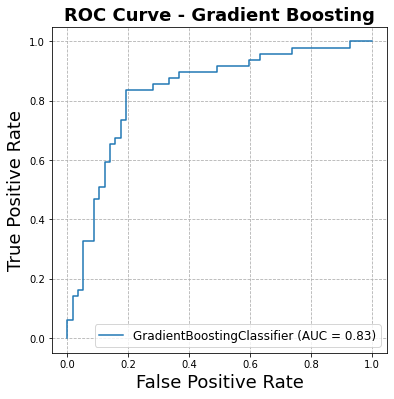

In [ ]:
# ver como esse modelo inicial se sai com os dados de teste
modelo_inicial_gb_1.fit(x_treino, y_treino)
testa_modelo(modelo_inicial_gb_1, x_teste, y_teste, "Gradient Boosting")

Acurácia = 0.764


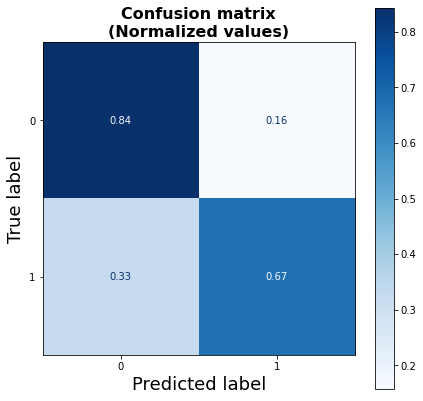

In [ ]:
# plotar a matriz de confusão dos dados de teste; valores normalizados
matriz_confusao(modelo_inicial_gb_1, x_teste, y_teste)

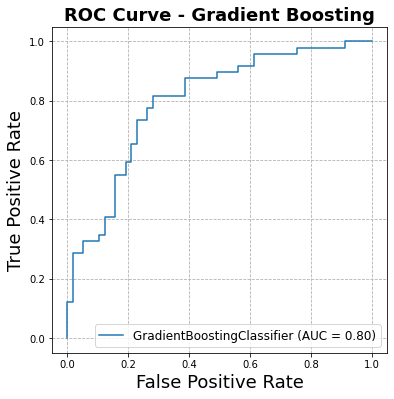

In [ ]:
# ver como esse modelo inicial se sai com os dados de teste
modelo_inicial_gb2.fit(x_treino, y_treino)
testa_modelo(modelo_inicial_gb2, x_teste, y_teste, "Gradient Boosting")

Acurácia = 0.726


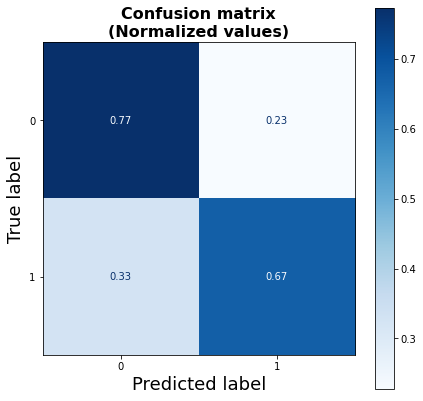

In [ ]:
# plotar a matriz de confusão dos dados de teste; valores normalizados
matriz_confusao(modelo_inicial_gb2, x_teste, y_teste)

**COMENTÁRIOS:**

Modelo: modelo_inicial_gb_1

- AUC = 0,83 
- ACURÁCIA = 0,764

Matriz de confusão:

- Verdadeiros Negativos (VN): esse modelo tem um bom desempenho em acertar a classe 0 *(quem não irá para UTI)*, com uma taxa de acerto dos VN igual a 0,84.

- Verdadeiros Positivos (VP): também teve um bom desempenho em prever os VP, com uma taxa de acerto igual a 0,67.

- Falsos Negativos (FN): esse modelo tem um bom valor de FN (0,33), 

- Falsos Positivos (FP): Esse modelo foi bom em evitar FP (0,16).

**CONCLUSÂO:**

Esse classificador, junto com o SVC, teve o melhor desempenho em prever a classe 1 (quem irá para UTI).

###**4.6 - RESUMO** 

AUC E ACURÁCIA DOS MODELOS TESTADOS ATÉ AGORA:

In [ ]:
# criar um df com as AUC e Acurácias dos modelos testados até agora
modelos_nomes = ["Dummy", "KNeighbors", "SVC", "Random_Forest", "Gradient_Boosting"]
modelos = [modelo_dummy_mf, modelo_kn_1, modelo_svc_2, modelo_rf_1, modelo_inicial_gb_1]

# plotar df
compara_modelos_e_cria_df_auc_acc(x_treino, y_treino, x_teste, y_teste, modelos, modelos_nomes)

,AUC_TESTE,ACURACIA_TESTE
Dummy,0.500000,0.537736
KNeighbors,0.810240,0.707547
SVC,0.808092,0.707547
Random_Forest,0.822234,0.754717
Gradient_Boosting,0.831006,0.764151


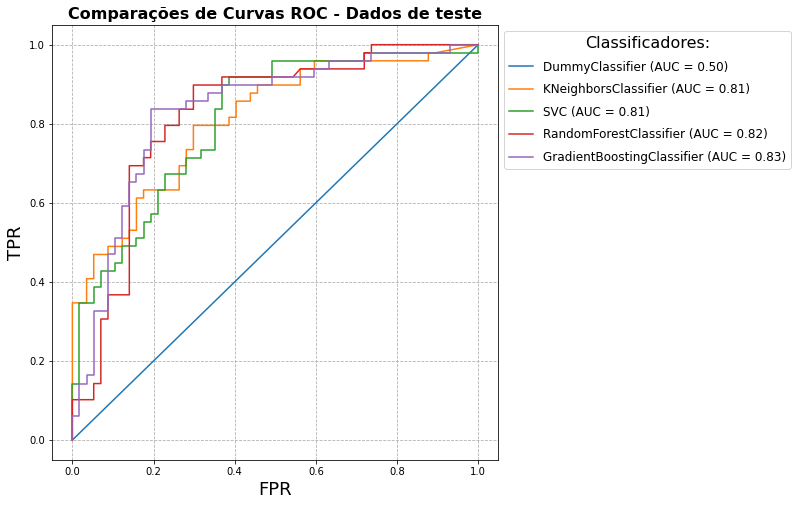

In [ ]:
compara_curvas_roc_modelos_diferentes(x_treino, y_treino, x_teste, y_teste, modelos)

###**4.7 - TESTAR OS MODELOS COM VÁRIOS DADOS DE TESTE**

**Testar os modelos com diferentes dados de teste**

Irei rodar cada modelo 30 vezes, cada vez com dados de treino e teste diferentes, passando seeds diferentes para o train_test_split, para ver se os modelos apresentam consistência nos resutados

In [ ]:
# gerar 30 seeds aleatórias
seeds = gera_seeds(30)

             Dummy            
Média AUC = 0.500 ± 0.000
Média Acurácia = 0.538 ± 0.000
------------------------------
          KNeighbors          
Média AUC = 0.720 ± 0.046
Média Acurácia = 0.628 ± 0.040
------------------------------
              SVC             
Média AUC = 0.742 ± 0.045
Média Acurácia = 0.667 ± 0.050
------------------------------
         Random_Forest        
Média AUC = 0.763 ± 0.040
Média Acurácia = 0.687 ± 0.048
------------------------------
       Gradient_Boosting      
Média AUC = 0.760 ± 0.047
Média Acurácia = 0.697 ± 0.046
------------------------------


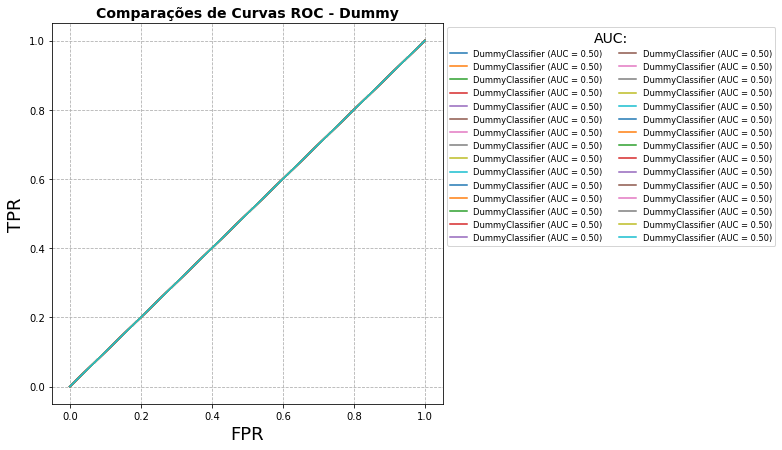

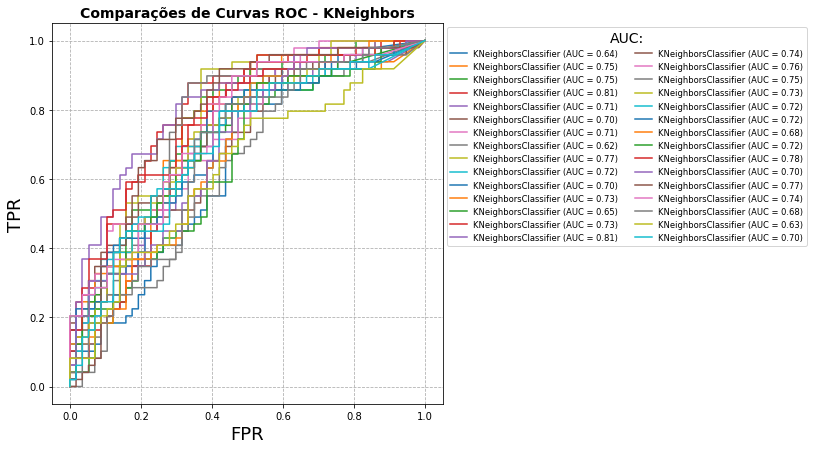

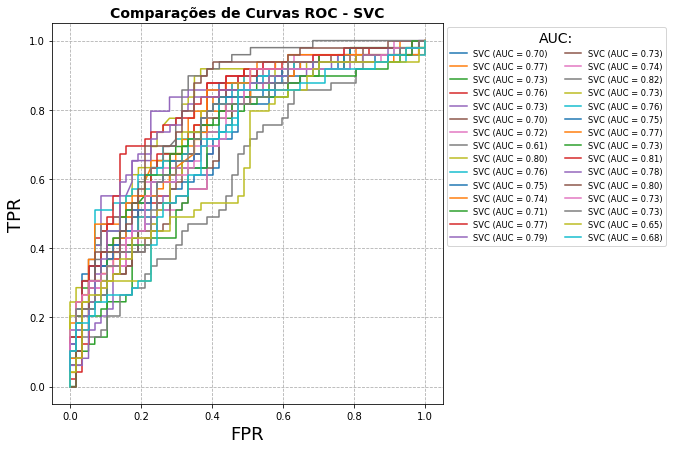

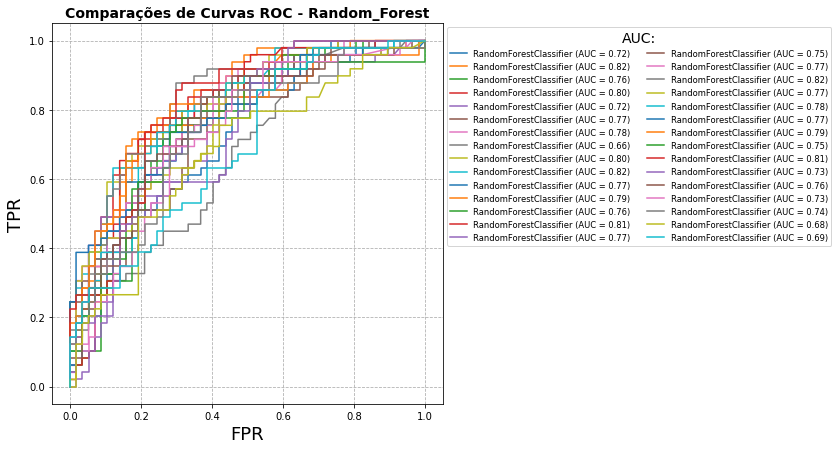

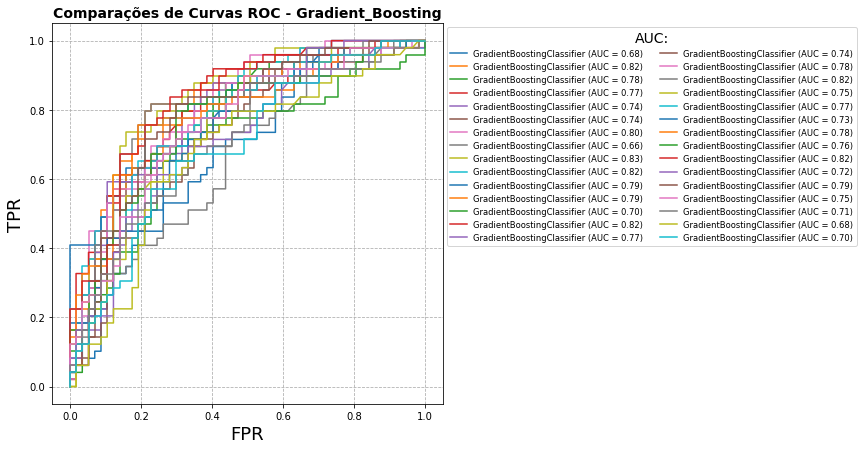

In [ ]:
modelos_nomes = ["Dummy", "KNeighbors", "SVC", "Random_Forest", "Gradient_Boosting"]
modelos = [modelo_dummy_mf, modelo_kn_1, modelo_svc_2, modelo_rf_1, modelo_inicial_gb_1]

for modelo, nome in zip (modelos, modelos_nomes):
  compara_curvas_roc_mesmo_modelo(dados_sirio, modelo, seeds, nome)


<font color="red">**Os melhores modelos, com os maiores valores de AUC e acurácia, foram:**

- **Random Forest** 

- **Gradient Boosting Classifier**


##**5 - OTIMIZAÇÃO DO RANDOM FOREST E GRADIENT BOOSTING**

Selecionei esses dois modelos, que foram os que tiveram as melhores performances, para tentar melhorar seus hiperparâmetros e obter melhores AUC e acurácia.

**Random Forest:**

In [ ]:
# esses são os valores de referência para o modelo - PONTO DE PARTIDA
modelo_rf_1 = RandomForestClassifier(n_estimators=50, max_features="auto", max_depth=2,
                                     bootstrap=True, oob_score=True, criterion="gini", 
                                     random_state=0)

# fazer CV
cross_val(modelo_rf_1, x_treino, y_treino)

Média AUC = 0.751 ± 0.083
IC inferior = 0.585
IC superior = 0.917
Amplitude do IC = 0.333


Otimização:

In [ ]:
# V1 --> Aumentou o AUC; reduziu STD e amplitude IC
modelo_rf_1_v1 = RandomForestClassifier(n_estimators=50, max_features="auto", max_depth=2, 
                                        bootstrap=True, oob_score=True, criterion="gini", 
                                        random_state=0,
                                        min_samples_leaf=4)

# fazer CV
cross_val(modelo_rf_1_v1, x_treino, y_treino)

Média AUC = 0.752 ± 0.081
IC inferior = 0.590
IC superior = 0.914
Amplitude do IC = 0.324


In [ ]:
# V2 --> Aumentou o AUC; reduziu STD e amplitude IC
modelo_rf_1_v2 = RandomForestClassifier(n_estimators=50, max_features="auto", max_depth=2, 
                                        bootstrap=True, oob_score=True, criterion="gini", 
                                        random_state=0,
                                        min_samples_leaf=10)

# fazer CV
cross_val(modelo_rf_1_v2, x_treino, y_treino)

Média AUC = 0.755 ± 0.080
IC inferior = 0.596
IC superior = 0.914
Amplitude do IC = 0.318


In [ ]:
# V3 --> Diminuiu STD e Amplitude IC ---> MELHOR MODELO
modelo_rf_1_v3 = RandomForestClassifier(n_estimators=50, max_features="auto", max_depth=2, 
                                        bootstrap=True, oob_score=True, criterion="gini", 
                                        random_state=0,
                                        min_samples_leaf=10,
                                        min_impurity_decrease=0.0004)

# fazer CV
cross_val(modelo_rf_1_v3, x_treino, y_treino)

Média AUC = 0.755 ± 0.079
IC inferior = 0.597
IC superior = 0.913
Amplitude do IC = 0.316


**Gradient Boosting:**

In [ ]:
# esses são os valores de referência para o modelo - PONTO DE PARTIDA
modelo_inicial_gb_1 = GradientBoostingClassifier(loss="exponential", max_depth=2, max_features="auto", 
                                                 min_samples_leaf=0.1, min_samples_split=2, 
                                                 n_estimators=50)                                

# fazer CV
cross_val(modelo_inicial_gb_1, x_treino, y_treino)

Média AUC = 0.736 ± 0.089
IC inferior = 0.559
IC superior = 0.913
Amplitude do IC = 0.354


Otimização:

In [ ]:
# V1 ---> Aumentou AUC, diminuiu STD e amplitude IC
modelo_inicial_gb_1_v1 = GradientBoostingClassifier(loss="exponential", max_depth=2, max_features="auto", 
                                                 min_samples_leaf=0.1, min_samples_split=2, n_estimators=50,
                                                 n_iter_no_change=11)
                                                                                

# fazer CV
cross_val(modelo_inicial_gb_1_v1, x_treino, y_treino)

Média AUC = 0.714 ± 0.115
IC inferior = 0.484
IC superior = 0.944
Amplitude do IC = 0.461


**Rodar os modelos otimizados:**

In [ ]:
# criar um df com as AUC e Acurácias dos modelos otimizados
modelos_nomes_otimizados = ["Random_Forest", "Gradient_Boosting"]
modelos_otimizados = [modelo_rf_1_v3, modelo_inicial_gb_1_v1]

# plotar df
compara_modelos_e_cria_df_auc_acc(x_treino, y_treino, x_teste, y_teste, modelos_otimizados, modelos_nomes_otimizados)

,AUC_TESTE,ACURACIA_TESTE
Random_Forest,0.836019,0.745283
Gradient_Boosting,0.799857,0.801887


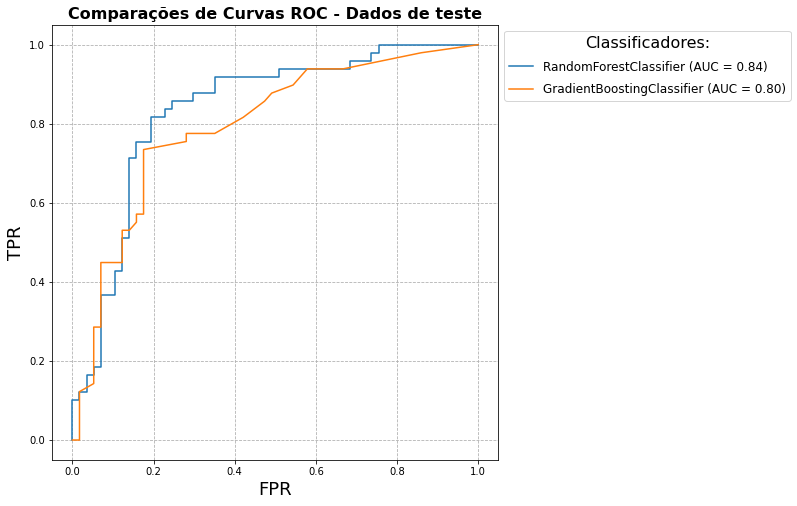

In [ ]:
compara_curvas_roc_modelos_diferentes(x_treino, y_treino, x_teste, y_teste, modelos_otimizados)

         Random_Forest        
Média AUC = 0.765 ± 0.040
Média Acurácia = 0.698 ± 0.048
------------------------------
       Gradient_Boosting      
Média AUC = 0.755 ± 0.044
Média Acurácia = 0.692 ± 0.043
------------------------------


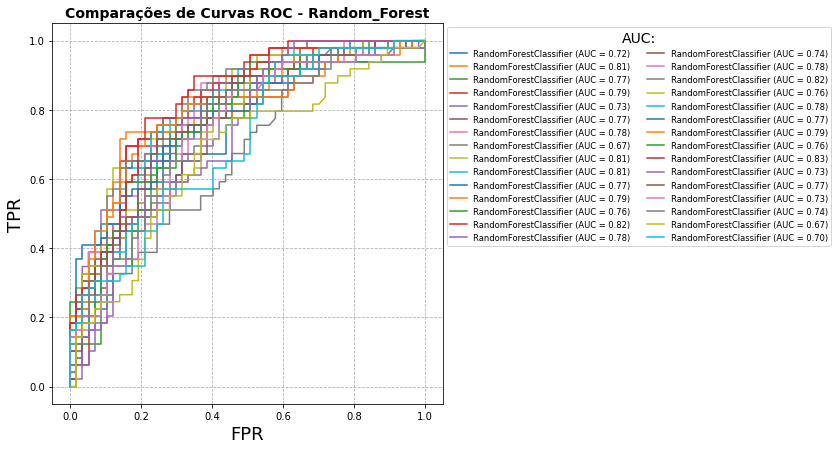

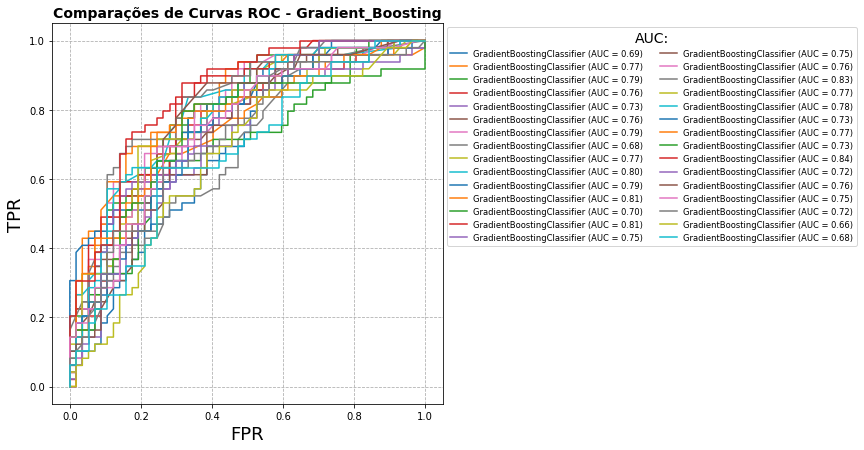

In [ ]:
# rodas os modelos com dados de treino e teste diferentes, 30x
modelos_nomes_otimizados = ["Random_Forest", "Gradient_Boosting"]
modelos_otimizados = [modelo_rf_1_v3, modelo_inicial_gb_1_v1]

for modelo, nome in zip (modelos_otimizados, modelos_nomes_otimizados):
  compara_curvas_roc_mesmo_modelo(dados_sirio, modelo, seeds, nome)

##**6 - CONCLUSÃO**

O modelo que resolvi escolher foi o **Random Forest**:

**modelo_rf_1_v3**

com os hiperparâmetros abaixo:


In [ ]:
modelo_rf_1_v3.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0004, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)>

Esse modelo, com os dados de treino e teste iniciais, apresentou:

AUC = 0,84

Acurácia = 0,74

E, após esse modelo ser rodado 30 vezes, com distintos dados de treino e teste, obteve:

Média AUC = 0,765 ± 0,040

Média Acurácia = 0,698 ± 0,048